# Spatial Correlation Analysis of Uncertainty Heatmaps

In this notebook we apply common spatial correlation metrics used for greyscale images to uncertainty heatmaps.

Goals:
- Extract meaningful scores reflecting spatial correlation of uncertainty values: Noise vs Structure, "Local vs Global Uncertainty", etc.
- Apply these metrics to toy data and real uncertainty maps, compare them and assess their reliability in practice.

Metrics:
- Moran's I
- Geary's C
- Grey-level Co-occurence Matrix (GLCM)

Note: For GLCM, we consider its correlation component. However, this is almost identical to Moran's I (for the choice of radius=1 and angle=0). Hence we will focus more on Moran's I.

In [2]:
# Firstly, we import necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from aggrigator.uncertainty_maps import UncertaintyMap
from aggrigator.methods import AggregationMethods as am
from aggrigator.summary import AggregationSummary
from aggrigator.strategylist import StrategyList
from aggrigator.util import generate_disk_bdry_mask, generate_disk_mask
from aggrigator.datasets import generate_binary_quadrant_array, generate_checkerboard_array

%load_ext autoreload
%autoreload 2

## Basic Example

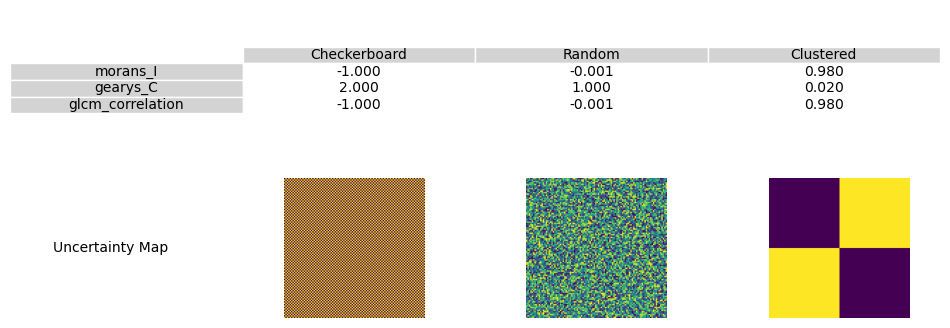

In [3]:
size = 100
array_1 = generate_checkerboard_array(size)
unc_map_1 = UncertaintyMap(array=array_1, mask=None, name="Checkerboard")

array_2 = np.random.random((100,100))
unc_map_2 = UncertaintyMap(array=array_2, mask=None, name="Random")

array_3 = generate_binary_quadrant_array(size)
unc_map_3 = UncertaintyMap(array=array_3, mask=None, name="Clustered")

summary = AggregationSummary(StrategyList.SPATIAL)
result = summary.apply_methods([unc_map_1, unc_map_2, unc_map_3], save_to_excel=False, do_plot=True, max_value=1.0)

# Analysis of Arctique Heatmaps

In [4]:
def get_arctique_slice_arrays(slice, dataset):
    # Load arrays
    path = os.path.join(os.getcwd(), "..", "..", "data", dataset)
    files = os.listdir(path)
    arrays = [np.load(os.path.join(path, file)) for file in files] # 3D arrays, shape (50,512,512)
    #arrays = [array[slice,:,:] for array in arrays]
    arrays = [array for array in arrays]
    arrays = [np.where(array < 0, 0, array) for array in arrays]
    return arrays, files

In [5]:
# Get spatial aggregation summary
SLICE = 25
DATASET = "arctique_uq_maps_patches"
#DATASET = "arctique_uq_maps"

arrays, filenames = get_arctique_slice_arrays(SLICE, DATASET)
unc_maps = [UncertaintyMap(array=array, mask=None, name=name) for array, name in zip(arrays, filenames)]
strategy_list = [(am.gearys_C, None), (am.morans_I, None), (am.glcm_correlation, None), (am.mean, None)]

summary = AggregationSummary(strategy_list, name=f"spatial_analysis_{DATASET}_slice_{SLICE}", num_cpus=12)
spatial_df = summary.apply_methods(unc_maps, save_to_excel=False, do_plot=False, max_value=1.0)
spatial_df

Using 8 CPUs.


,Name,instance_noise_0_blood_cells_0_00_dropout_au.npy_0_0.npy,instance_noise_0_blood_cells_0_00_dropout_au.npy_0_1.npy,instance_noise_0_blood_cells_0_00_dropout_au.npy_0_2.npy,instance_noise_0_blood_cells_0_00_dropout_au.npy_0_3.npy,instance_noise_0_blood_cells_0_00_dropout_au.npy_0_4.npy,instance_noise_0_blood_cells_0_00_dropout_au.npy_0_5.npy,instance_noise_0_blood_cells_0_00_dropout_au.npy_0_6.npy,instance_noise_0_blood_cells_0_00_dropout_au.npy_0_7.npy,instance_noise_0_blood_cells_0_00_dropout_au.npy_1_0.npy,...,semantic_noise_0_nuclei_intensity_1_00_tta_pu.npy_6_6.npy,semantic_noise_0_nuclei_intensity_1_00_tta_pu.npy_6_7.npy,semantic_noise_0_nuclei_intensity_1_00_tta_pu.npy_7_0.npy,semantic_noise_0_nuclei_intensity_1_00_tta_pu.npy_7_1.npy,semantic_noise_0_nuclei_intensity_1_00_tta_pu.npy_7_2.npy,semantic_noise_0_nuclei_intensity_1_00_tta_pu.npy_7_3.npy,semantic_noise_0_nuclei_intensity_1_00_tta_pu.npy_7_4.npy,semantic_noise_0_nuclei_intensity_1_00_tta_pu.npy_7_5.npy,semantic_noise_0_nuclei_intensity_1_00_tta_pu.npy_7_6.npy,semantic_noise_0_nuclei_intensity_1_00_tta_pu.npy_7_7.npy
0,gearys_C,0.105870,0.080270,0.070317,0.094234,0.079509,0.082196,0.105276,0.092846,0.071572,...,0.046620,0.035602,0.016999,0.007849,0.044736,0.054073,0.049630,0.028418,0.007407,0.016595
1,morans_I,0.888147,0.915018,0.928079,0.907510,0.912462,0.914603,0.886578,0.909451,0.924021,...,0.955631,0.953090,0.959255,0.985794,0.942299,0.944902,0.942491,0.961597,0.989199,0.944723
2,glcm_correlation,0.873098,0.926279,0.924429,0.906238,0.925685,0.917197,0.898751,0.901686,0.923474,...,0.953596,0.967500,0.981271,0.992733,0.959715,0.953158,0.955854,0.972462,0.994148,0.982212
3,mean,0.261011,0.304160,0.253157,0.338584,0.195756,0.182539,0.247091,0.303962,0.250861,...,0.437116,0.383773,0.158584,0.239274,0.428514,0.513526,0.473029,0.382536,0.158966,0.106933


## Plot Edge Case Heatmaps

In [6]:
# Plot 10 unc maps with lowest and highest values
import matplotlib.pyplot as plt

def plot_extremal_heatmaps(arrays, method, N=10):
    method_values = {i: spatial_df[spatial_df["Name"]==method][filenames[i]].values[0] for i in range(len(arrays))}

    vals_sorted_ascending = [idx for idx, val in sorted(method_values.items(), key=lambda x: x[1])]
    min_heatmaps = {i: arrays[i] for i in vals_sorted_ascending[:N]}
    max_heatmaps = {i: arrays[i] for i in vals_sorted_ascending[-N:]}

    fig, axes = plt.subplots(1, N, figsize=(3*N, 3))
    # Plot each image in a separate subplot
    for ax, (idx, img) in zip(axes, min_heatmaps.items()):
        ax.imshow(img, cmap="viridis", vmin=0, vmax=1)  # Plot as grayscale
        ax.axis("off")  # Hide axes for better visualization
        val = f"{method_values[idx]:.3f}"
        ax.text(0.5, -0.15, val, fontsize=12, ha="center", va="center", transform=ax.transAxes)  # Add text
    fig.suptitle(f"{N} minimal heatmaps for {method}", fontsize=16)

    fig, axes = plt.subplots(1, N, figsize=(3*N, 3))
    # Plot each image in a separate subplot
    for ax, (idx, img) in zip(axes, max_heatmaps.items()):
        ax.imshow(img, cmap="viridis", vmin=0, vmax=1)  # Plot as grayscale
        ax.axis("off")  # Hide axes for better visualization
        val = f"{method_values[idx]:.3f}"
        ax.text(0.5, -0.15, val, fontsize=12, ha="center", va="center", transform=ax.transAxes)  # Add text
    fig.suptitle(f"{N} maximal heatmaps for {method}", fontsize=16)

    plt.show()


Moran's I


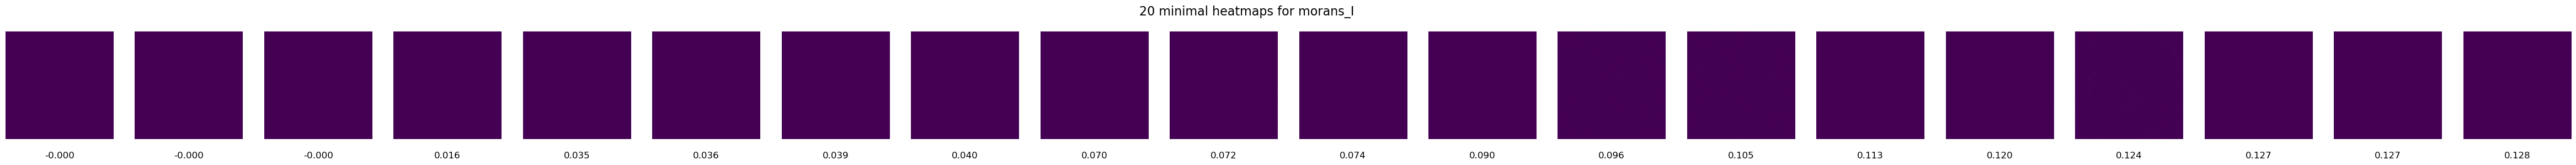

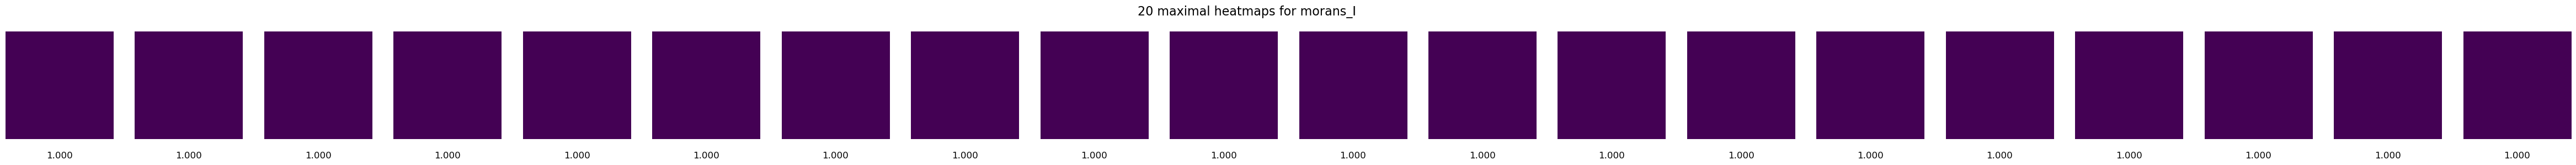

Geary's C


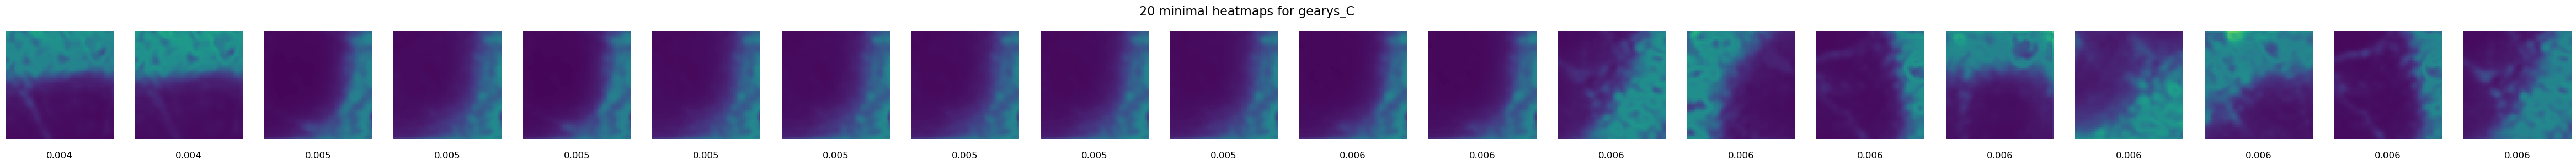

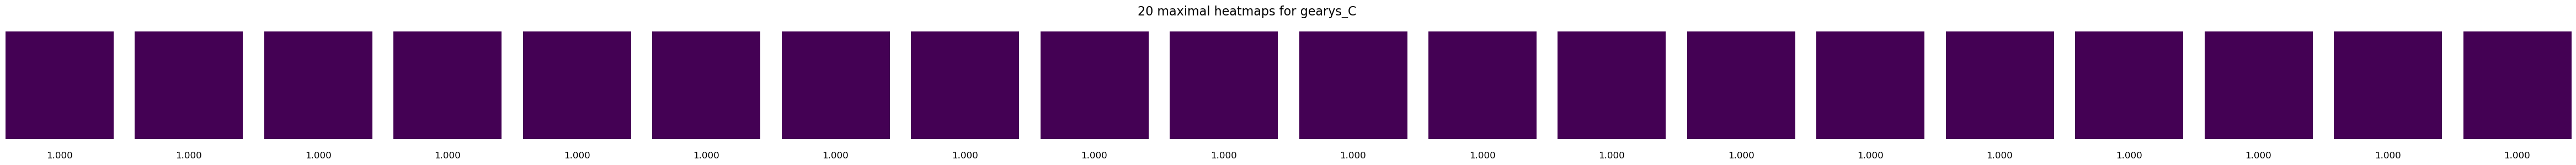

GLCM


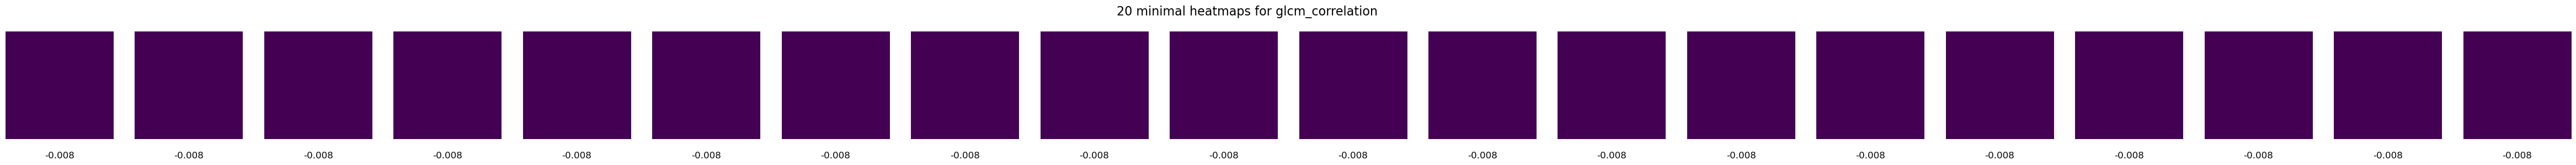

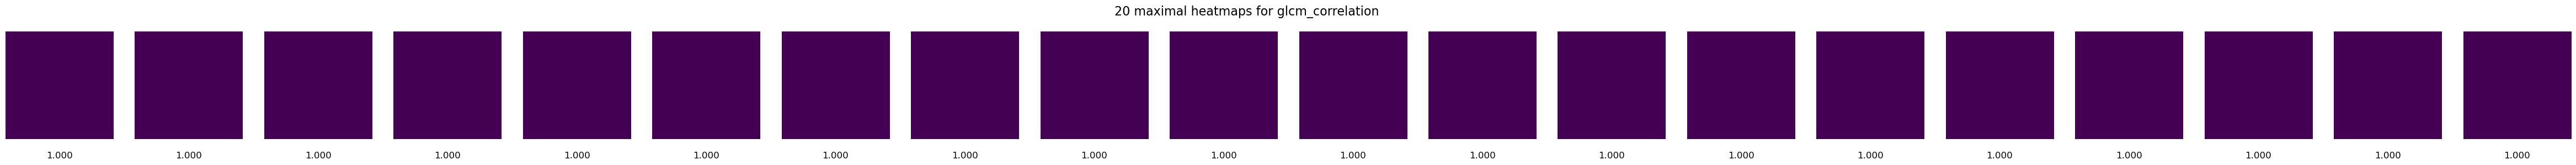

In [7]:
# Moran's I
print("Moran's I")
plot_extremal_heatmaps(arrays, "morans_I", 20)
# Geary's C
print("Geary's C")
plot_extremal_heatmaps(arrays, "gearys_C", 20)
# GLCM
print("GLCM")
plot_extremal_heatmaps(arrays, "glcm_correlation", 20)

## Correlation Matrix

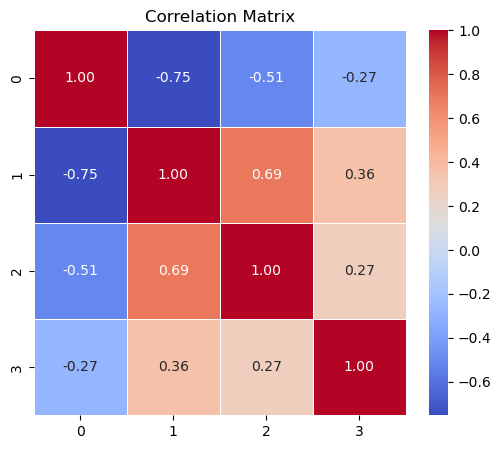

In [8]:
# Compute correlation matrix
df = spatial_df[filenames].T
corr_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

##  Range of Aggregation Scores

For each metric we are interested how well the capture the variety of uncertainty heatmaps present in the dataset.
Ideally, a good score should have a high range of values, indicating its ability to capture qualitative differences across heatmaps.

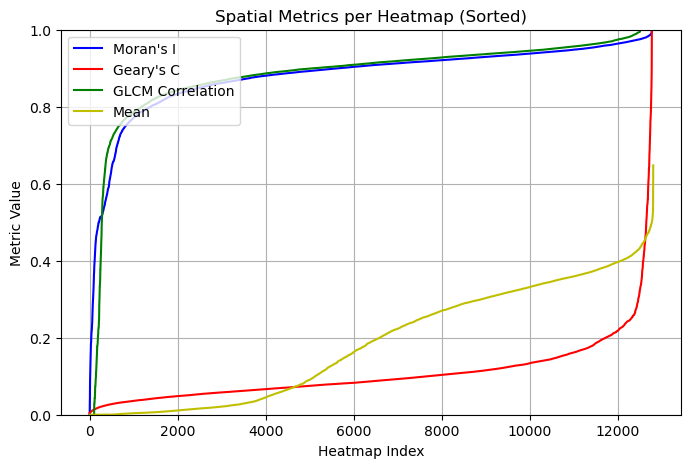

In [9]:
def sort_vals(df, method):
    geary_vals = df[df["Name"]==method].values[:,1:].tolist()[0]
    sorted_indices = np.argsort(geary_vals)  # Indices that would sort geary_vals
    sorted_values = np.array(geary_vals)[sorted_indices]  # Sort values
    return sorted_values

moran_val = sort_vals(spatial_df, "morans_I")
geary_val = sort_vals(spatial_df, "gearys_C")
glcm_val = sort_vals(spatial_df, "glcm_correlation")
mean_val = sort_vals(spatial_df, "mean")
x = [i for i, _ in enumerate(filenames)]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, moran_val, linestyle="-", color="b", label="Moran's I")
plt.plot(x, geary_val, linestyle="-", color="r", label="Geary's C")
plt.plot(x, glcm_val, linestyle="-", color="g", label="GLCM Correlation")
plt.plot(x, mean_val, linestyle="-", color="y", label="Mean")
# Labels, title, and legend
plt.xlabel("Heatmap Index")
plt.ylabel("Metric Value")
plt.title("Spatial Metrics per Heatmap (Sorted)")
# Get max y-value for setting the axis limits
max_y = max(max(moran_val), max(geary_val), max(glcm_val))
plt.ylim(0, max_y)  # Set y-axis range
plt.grid(True)
plt.legend(loc="upper left")  # Show legend with appropriate labels
# Show plot
plt.show()


# Counterexamples

Goal: Find heatmaps that have similar mean but different spatial correlation metrics.

In [10]:
method_names = spatial_df["Name"].tolist()
# Sort all columns based on values in the "mean" row
sorted_columns = spatial_df[filenames].loc[method_names.index("mean")].sort_values().index
# Reorder columns in reduced_df (keeping "Name" as the first column)
sorted_df = spatial_df[["Name"]+sorted_columns.tolist()]
sorted_df

,Name,instance_noise_0_blood_cells_1_00_softmax_pu.npy_6_1.npy,instance_noise_0_blood_cells_0_25_softmax_pu.npy_5_1.npy,instance_noise_0_blood_cells_1_00_softmax_pu.npy_1_6.npy,instance_noise_0_blood_cells_1_00_softmax_pu.npy_2_6.npy,instance_noise_0_blood_cells_0_25_softmax_pu.npy_1_6.npy,instance_noise_0_blood_cells_0_25_softmax_pu.npy_2_6.npy,instance_noise_0_nuclei_intensity_1_00_softmax_pu.npy_5_1.npy,instance_noise_0_nuclei_intensity_1_00_softmax_pu.npy_1_6.npy,instance_noise_0_nuclei_intensity_0_00_softmax_pu.npy_2_6.npy,...,instance_noise_0_blood_cells_1_00_tta_pu.npy_2_1.npy,semantic_noise_0_nuclei_intensity_1_00_tta_au.npy_2_1.npy,semantic_noise_0_nuclei_intensity_1_00_tta_au.npy_3_0.npy,semantic_noise_0_nuclei_intensity_1_00_tta_pu.npy_3_0.npy,instance_noise_0_nuclei_intensity_0_50_tta_pu.npy_5_7.npy,instance_noise_0_blood_cells_1_00_tta_pu.npy_2_0.npy,instance_noise_0_nuclei_intensity_0_75_tta_au.npy_5_7.npy,instance_noise_0_nuclei_intensity_1_00_tta_au.npy_5_7.npy,instance_noise_0_nuclei_intensity_0_75_tta_pu.npy_5_7.npy,instance_noise_0_nuclei_intensity_1_00_tta_pu.npy_5_7.npy
0,gearys_C,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.106156,0.050103,0.065747,0.059716,0.137760,0.080958,0.140982,0.078145,0.135804,0.076172
1,morans_I,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.895672,0.951898,0.923785,0.931608,0.863576,0.920154,0.857284,0.916328,0.863300,0.920231
2,glcm_correlation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.883665,0.953571,0.931656,0.939277,0.869076,0.903776,0.861422,0.921345,0.864947,0.923602
3,mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.519348,0.519552,0.525284,0.527347,0.528201,0.531184,0.555187,0.590572,0.600942,0.647742


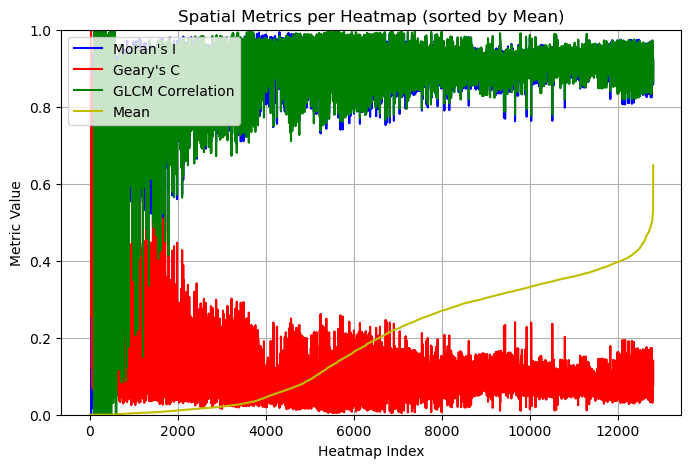

In [11]:
moran_val = list(sorted_df[sorted_columns].loc[method_names.index("morans_I")])
geary_val = list(sorted_df[sorted_columns].loc[method_names.index("gearys_C")])
glcm_val = list(sorted_df[sorted_columns].loc[method_names.index("glcm_correlation")])
mean_val = list(sorted_df[sorted_columns].loc[method_names.index("mean")])
x = [i for i, _ in enumerate(filenames)]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, moran_val, linestyle="-", color="b", label="Moran's I")
plt.plot(x, geary_val, linestyle="-", color="r", label="Geary's C")
plt.plot(x, glcm_val, linestyle="-", color="g", label="GLCM Correlation")
plt.plot(x, mean_val, linestyle="-", color="y", label="Mean")
# Labels, title, and legend
plt.xlabel("Heatmap Index")
plt.ylabel("Metric Value")
plt.title("Spatial Metrics per Heatmap (sorted by Mean)")
# Get max y-value for setting the axis limits
max_y = max(max(moran_val), max(geary_val), max(glcm_val))
plt.ylim(0, max_y)  # Set y-axis range
plt.grid(True)
plt.legend(loc="upper left")  # Show legend with appropriate labels
# Show plot
plt.show()

We see that only Geary's C does have strong variance in values among heatmaps sharing the same mean.
Let us extract heatmaps that have minimal and maximal Geary's C while having similar mean.

In [12]:
# Find a heatmap file that has similar mean (lying between a and b) but different Geary's C
def min_max_heatmap(method, a, b):
    values = sorted_df[filenames].astype(float)
    filtered_columns = values.loc[method_names.index("mean")].between(a, b)
    selected_columns = values.columns[filtered_columns].tolist()
    selected_df = values[selected_columns]

    # Extract row with index 1
    method_row = selected_df.loc[method_names.index(method)]
    # Find column names for min and max values
    min_col = method_row.idxmin()  # Column with min value
    print("Min: ", method_row.min(), min_col)
    max_col = method_row.idxmax()  # Column with max value
    print("Max: ", method_row.max(), max_col)
    return [min_col, max_col]

def sorted_heatmaps_by_mean(method, a, b):
    values = sorted_df[filenames].astype(float)
    filtered_columns = values.loc[method_names.index("mean")].between(a, b)
    selected_columns = values.columns[filtered_columns].tolist()
    selected_df = values[selected_columns]

    # Extract row with index 1
    method_row = selected_df.loc[method_names.index(method)]
    file_val_dict = method_row.to_dict()
    sorted_file_val_dict = dict(sorted(file_val_dict.items(), key=lambda x: x[1]))
    return sorted_file_val_dict

min_max_heatmap("gearys_C", 0.3, 0.5)

sorted_heatmaps_by_mean("gearys_C", 0.3, 0.5)

Min:  0.010166734277714168 semantic_noise_0_nuclei_intensity_1_00_tta_au.npy_4_0.npy
Max:  0.24041743731709814 instance_noise_0_nuclei_intensity_0_25_softmax_pu.npy_5_7.npy


{'semantic_noise_0_nuclei_intensity_1_00_tta_au.npy_4_0.npy': 0.010166734277714168,
 'semantic_noise_0_nuclei_intensity_1_00_tta_pu.npy_4_0.npy': 0.010229769322392465,
 'semantic_noise_0_nuclei_intensity_1_00_tta_pu.npy_4_2.npy': 0.010979152404508303,
 'semantic_noise_0_nuclei_intensity_1_00_tta_au.npy_4_2.npy': 0.01112619653969887,
 'semantic_noise_0_nuclei_intensity_1_00_tta_au.npy_4_7.npy': 0.012451385439688264,
 'semantic_noise_0_nuclei_intensity_1_00_tta_pu.npy_4_7.npy': 0.013930673301553995,
 'semantic_noise_0_nuclei_intensity_0_75_tta_pu.npy_4_2.npy': 0.0177412183808239,
 'instance_noise_0_nuclei_intensity_1_00_tta_pu.npy_0_6.npy': 0.019545104412521507,
 'semantic_noise_0_nuclei_intensity_0_75_tta_au.npy_4_2.npy': 0.019718640558534235,
 'semantic_noise_0_nuclei_intensity_1_00_ensemble_au.npy_4_2.npy': 0.022506303987296278,
 'semantic_noise_0_nuclei_intensity_1_00_ensemble_pu.npy_4_2.npy': 0.02252799951604383,
 'semantic_noise_0_nuclei_intensity_1_00_dropout_pu.npy_4_2.npy': 0.02

Example for Geary's C
Min:  0.02771677920321102 semantic_noise_0_nuclei_intensity_1_00_tta_au.npy_7_5.npy
Max:  0.19363700423258903 instance_noise_0_blood_cells_0_25_ensemble_pu.npy_1_2.npy


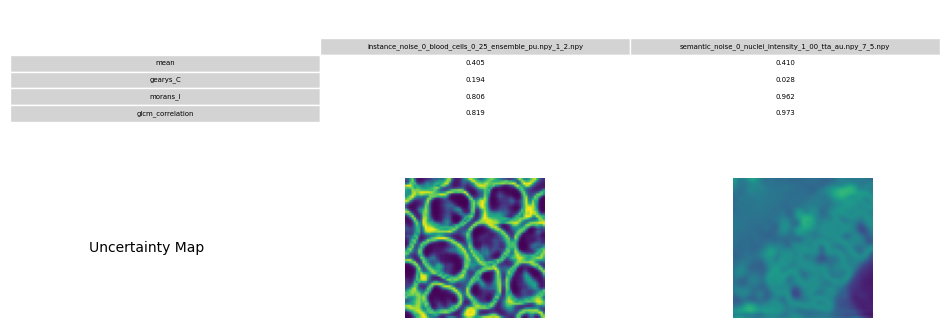

,Name,instance_noise_0_blood_cells_0_25_ensemble_pu.npy_1_2.npy,semantic_noise_0_nuclei_intensity_1_00_tta_au.npy_7_5.npy
0,mean,0.404628,0.409567
1,gearys_C,0.193637,0.027717
2,morans_I,0.806320,0.962032
3,glcm_correlation,0.819353,0.973438


In [13]:
# Plot heatmaps having similar mean but different spatial metric scores:

print("Example for Geary's C")
min_max_files = min_max_heatmap("gearys_C", 0.4, 0.7)
min_max_unc_maps = [unc_map for unc_map in unc_maps if unc_map.name in min_max_files]

strategy_list = [(am.mean, None), (am.gearys_C, None), (am.morans_I, None), (am.glcm_correlation, None)]
summary = AggregationSummary(strategy_list, name="min_max_gearys_C")
summary.apply_methods(min_max_unc_maps, save_to_excel=False, do_plot=True, max_value=1.0)


In [14]:
min_max_files

['semantic_noise_0_nuclei_intensity_1_00_tta_au.npy_7_5.npy',
 'instance_noise_0_blood_cells_0_25_ensemble_pu.npy_1_2.npy']

Example for Geary's C


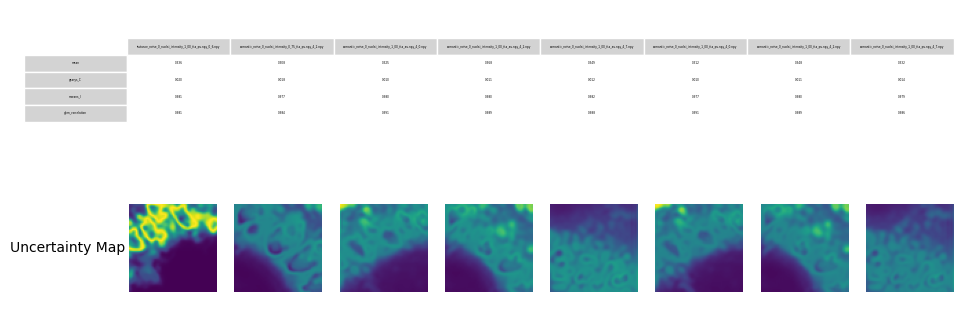

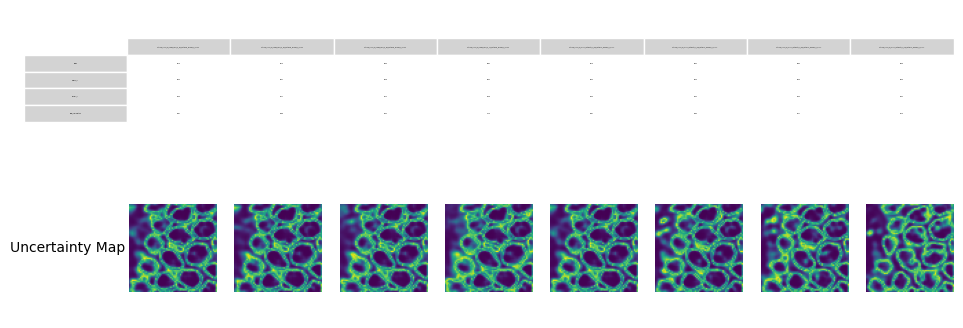

,Name,instance_noise_0_blood_cells_0_00_softmax_pu.npy_5_7.npy,instance_noise_0_blood_cells_0_25_softmax_pu.npy_5_7.npy,instance_noise_0_blood_cells_0_50_softmax_pu.npy_5_7.npy,instance_noise_0_blood_cells_0_75_softmax_pu.npy_5_7.npy,instance_noise_0_nuclei_intensity_0_00_softmax_pu.npy_5_7.npy,instance_noise_0_nuclei_intensity_0_25_softmax_pu.npy_5_7.npy,instance_noise_0_nuclei_intensity_0_50_softmax_pu.npy_5_7.npy,instance_noise_0_nuclei_intensity_0_75_softmax_pu.npy_5_7.npy
0,mean,0.315961,0.315262,0.329391,0.354182,0.315961,0.322206,0.332742,0.346408
1,gearys_C,0.233241,0.230660,0.228302,0.202411,0.233241,0.240417,0.239417,0.236392
2,morans_I,0.768677,0.771102,0.773852,0.797719,0.768677,0.761998,0.763146,0.763516
3,glcm_correlation,0.787244,0.788194,0.793673,0.818778,0.787244,0.779583,0.776730,0.779177


In [14]:
# Plot heatmaps having similar mean but different spatial metric scores:

print("Example for Geary's C")
sorted_maps = sorted_heatmaps_by_mean("gearys_C", 0.3, 0.5)
min_maps = [unc_map for unc_map in unc_maps if unc_map.name in list(sorted_maps.keys())[:8]]

strategy_list = [(am.mean, None), (am.gearys_C, None), (am.morans_I, None), (am.glcm_correlation, None)]
summary = AggregationSummary(strategy_list, name="Minimal Gearys")
summary.apply_methods(min_maps, save_to_excel=False, do_plot=True, max_value=1.0)


# Max
max_maps = [unc_map for unc_map in unc_maps if unc_map.name in list(sorted_maps.keys())[-8:]]

strategy_list = [(am.mean, None), (am.gearys_C, None), (am.morans_I, None), (am.glcm_correlation, None)]
summary = AggregationSummary(strategy_list, name="Maximal Gearys")
summary.apply_methods(max_maps, save_to_excel=False, do_plot=True, max_value=1.0)





1) 'semantic_noise_0_nuclei_intensity_1_00_tta_pu.npy_4_0.npy',
 'instance_noise_0_blood_cells_0_00_softmax_pu.npy_5_7.npy'

## TODO: Analysis of Noise Levels

In [15]:
def filter_filenames(filenames, keywords):
    return [f for f in filenames if all(kw in f for kw in keywords)]

import re
def extract_noise_level(filename):
    """
    Extracts the noise level from a filename and converts it to a float.

    :param filename: String representing the filename.
    :return: Float noise level or None if not found.
    """
    match = re.search(r'_(\d+)_(\d+)_', filename)
    if match:
        return float(f"{match.group(1)}.{match.group(2)}")
    return None  # Return None if no match found
    

tta_pu_files = filter_filenames(files, ['tta', 'pu'])
tta_pu_files

NameError: name 'files' is not defined

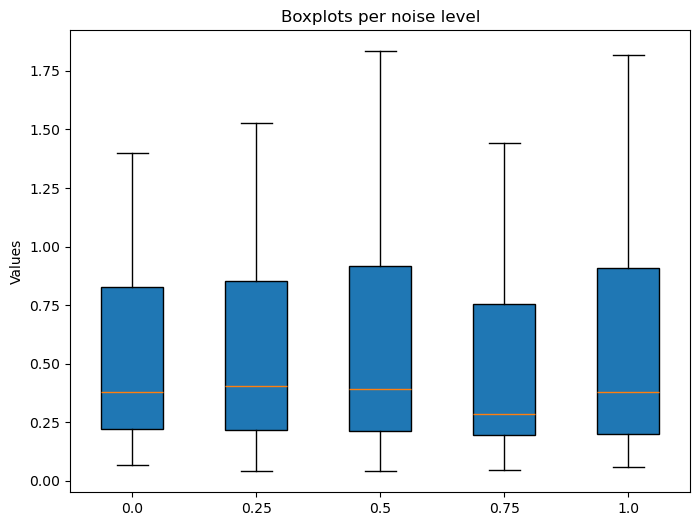

In [ ]:
# Boxplot of spatial values across all noise levels

noise_levels = [0.0, 0.25, 0.5, 0.75, 1.0]#list(set([extract_noise_level(f) for f in files]))
indices_per_level = {level : [idx for idx, f in enumerate(files) if extract_noise_level(f)==level] for level in noise_levels}
indices_per_level

def values_per_level(df, level, method):
    indices = indices_per_level[level]
    #print(df[df["Name"]==method][indices].values[0])
    geary_vals = df[df["Name"]==method][indices].values[0]
    sorted_indices = np.argsort(geary_vals)  # Indices that would sort geary_vals
    sorted_values = np.array(geary_vals)[sorted_indices]  # Sort values
    return list(sorted_values)

geray_data = [values_per_level(spatial_df, level, "gearys_C") for level in noise_levels]
geray_data

# Create a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(geray_data, vert=True, patch_artist=True)

# Set labels
plt.xticks([1, 2, 3, 4, 5], [level for level in noise_levels])
plt.ylabel("Values")
plt.title("Boxplots per noise level")

# Show plot
plt.show()